In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import Planetoid, NELL
import json
import random
import numpy as np


In [ ]:
# Define the GCN model
class GCN(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)


In [ ]:
# Load the datasets
dataset_names = [
    "NELL",
    "Cora",
    "Citeseer",
    "Pubmed",
]
datasets = {
    "NELL": NELL(root="data/NELL"),
    "Cora": Planetoid(root="data/Planetoid/Cora", name="Cora"),
    "Citeseer": Planetoid(root="data/Planetoid/Citeseer", name="Citeseer"),
    "Pubmed": Planetoid(root="data/Planetoid/Pubmed", name="Pubmed"),
}


In [ ]:
# Training function
def train(model, data, optimizer):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss


# Testing function
def test(model, data):
    model.eval()
    logits = model(data)
    accs = []
    for mask in [data.train_mask, data.val_mask, data.test_mask]:
        pred = logits[mask].max(1)[1]
        acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
        accs.append(acc)
    return accs


In [ ]:
# Set random seed for reproducibility
def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.cuda.manual_seed_all(seed)


In [ ]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Results tracking for all random seeds
all_best_accs = {
    name: {seed: {"test": 0, "epoch": 0} for seed in range(8)} for name in dataset_names
}
patience = 25

# Loop through datasets and seeds
for dataset_name, dataset in datasets.items():
    print(f"\nProcessing dataset: {dataset_name}")
    data = dataset[0].to(device)  # Move the dataset to device

    for seed in range(8):
        print(f"\nRunning with seed {seed} for {dataset_name}...")

        set_seed(seed)
        model = GCN(
            num_features=dataset.num_features,
            hidden_channels=16,
            num_classes=dataset.num_classes,
        ).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

        best_val_acc = 0
        best_test_acc = 0
        best_epoch = 0
        no_improvement = 0

        for epoch in range(200):
            model.train()
            total_loss = 0

            # Training loop (full graph, no batches)
            loss = train(model, data, optimizer)
            total_loss += loss.item()

            # Evaluate model
            train_acc, val_acc, test_acc = test(model, data)
            print(
                f"[{dataset_name}] Seed {seed} - Epoch: {epoch+1}, Loss: {total_loss:.4f}, "
                f"Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}"
            )

            # Early stopping based on validation accuracy
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_test_acc = test_acc
                best_epoch = epoch + 1
                no_improvement = 0
            else:
                no_improvement += 1

            # Track best accuracies for each seed and dataset
            all_best_accs[dataset_name][seed] = {
                "test": best_test_acc,
                "epoch": best_epoch,
            }

            if no_improvement >= patience:
                print(
                    f"Early stopping at epoch {epoch+1} for {dataset_name} due to no improvement."
                )
                break

        print(
            f"Best Test Accuracy for {dataset_name} with Seed {seed}: {best_test_acc:.4f} at Epoch: {best_epoch}"
        )


In [ ]:
# Save results to JSON
with open("best_accuracies_per_seed.json", "w") as f:
    json.dump(all_best_accs, f, indent=4)

print("Best accuracies for each seed saved to 'best_accuracies_per_seed.json'")


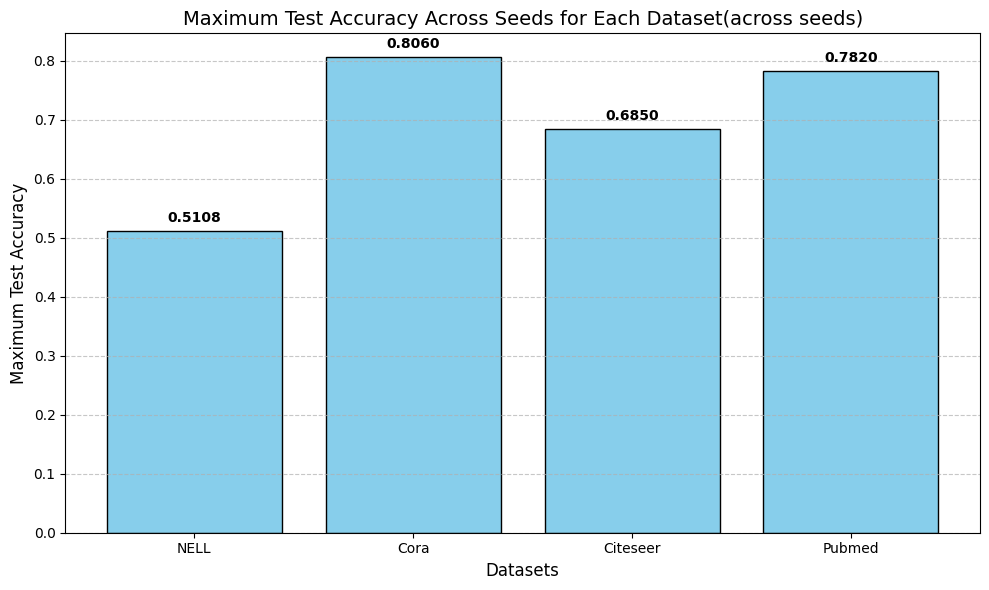

In [42]:
import matplotlib.pyplot as plt
import numpy as np

# Extract the maximum test accuracy across seeds for each dataset
max_test_accuracies = {}

for dataset_name, seeds_data in all_best_accs.items():
    # Get the maximum test accuracy for each dataset across all seeds
    max_test_accuracies[dataset_name] = max(seed_data["test"] for seed_data in seeds_data.values())

# Prepare data for plotting
dataset_names = list(max_test_accuracies.keys())
max_accuracies = list(max_test_accuracies.values())

# Plot the maximum test accuracies
fig, ax = plt.subplots(figsize=(10, 6))

# Create a bar plot
bars = ax.bar(dataset_names, max_accuracies, color='skyblue', edgecolor='black')

# Annotate each bar with the maximum test accuracy value
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, yval + 0.01, f"{yval:.4f}", ha='center', va='bottom', fontsize=10, color='black', fontweight='bold')

# Customize plot
ax.set_xlabel('Datasets', fontsize=12)
ax.set_ylabel('Maximum Test Accuracy', fontsize=12)
ax.set_title('Maximum Test Accuracy Across Seeds for Each Dataset(across seeds)', fontsize=14)
ax.grid(True, axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.savefig('best_accuracy_per_dataset_across_seeds.png', dpi=300)  # Save with high resolution
plt.show()